In [1]:
import jax
from jax import vmap
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq


def F(x):
    return fftshift(fft(x))

def get_ks(N):
    return fftshift(fftfreq(N, 1./N))

def iF(x):
    return ifft(ifftshift(x))

def diffuse_ft(x_ft, sigma):
    return x_ft*jnp.exp(-sigma**2*get_ks(len(x_ft))**2/2)

def shift_ft(x_ft, a):
    return x_ft*jnp.exp(-1j*a*get_ks(len(x_ft)))

def dirac_ft(N):
    return jnp.ones((N,))

def smooth_dirac_ft(N, x0, sigma):
    return diffuse_ft(shift_ft(dirac_ft(N), x0), sigma)

def smooth_diracs_ft(N, x0s, sigma):
    return jnp.sum(vmap(lambda x0: smooth_dirac_ft(N, x0, sigma))(x0s), axis=0)

def decimate_ft(x_ft, M, retain_shape=True):
    # Eliminate high frequencies
    N = len(x_ft)
    if retain_shape:
        x_ft = ifftshift(x_ft)
        x_ft = x_ft.at[M:N-M].set(0.) 
        return fftshift(x_ft)
    else:
        return x_ft[N//2-M:N//2+M]


def assign_to_segment(x, center_x):
    """Assigns a point to the left or right segment based on its position relative to center_x."""
    return int(x > center_x)

def split_points_1d(i_list, x_list, center_x):
    """Splits points into left and right segments."""
    segments_i = [[], []]
    segments_x = [[], []]
    for i, x in zip(i_list, x_list):
        idx = assign_to_segment(x, center_x)
        segments_i[idx].append(i)
        segments_x[idx].append(x)
    return segments_i, segments_x

def get_1d_tree(point_ids, points_x, center_x, width, max_points=1, data_func=None):
    """Recursively constructs a 1D tree."""
    if len(points_x) <= max_points:
        children = None
    else:
        segments_i, segments_x = split_points_1d(point_ids, points_x, center_x)
        center_x_list = (center_x - width / 4, center_x + width / 4)
        widths = (width / 2, width / 2)
        children = tuple(
            get_1d_tree(i, x, cx, w, max_points, data_func)
            for i, x, cx, w in zip(segments_i, segments_x, center_x_list, widths)
        )
    if data_func is None:
        data = None
    else:
        data = data_func(point_ids, points_x, center_x, width)
    return {'children': children, 'data': (point_ids, points_x, center_x, width, data)}

def unpack(tree):
    return tree['children'], tree['data']
          
def plot_1d_tree(tree, depth=0, data_plotter=None, **kwargs):
    """Visualizes the 1D tree as a series of line segments."""
    if not isinstance(tree, dict):
        print(tree)
    children, (ids, xs, cx, w, data) = unpack(tree)
    plt.plot([cx-w/2, cx-w/2, cx+w/2, cx + w/2], [-depth-1, -depth, -depth, -depth-1], **kwargs)
    if data_plotter is not None:
        data_plotter(depth, ids, xs, cx, w, data)
    if children is not None:
        for child in children:
            plot_1d_tree(child, depth+1, data_plotter, **kwargs)

def data_plotter(depth, ids, xs, cx, w, data):
    if data is not None:
        N = len(data)
        t = jnp.linspace(cx-w, cx+w, N)
        f = iF(data).real
        #f = (f - jnp.min(f))/(jnp.max(f) - jnp.min(f))*0.1 - depth - 0.5
        f = f*0.1 - depth - 0.5
        plt.plot(t[N//4:-N//4], f[N//4:-N//4])
        plt.scatter(xs, [-depth-0.6]*len(xs), color='red', s=10)

def get_data_1d(point_ids, points_x, center_x, width):
    """Computes the data for the 1D tree. In this case, 
    we compute the fft of the empirical density function for the points."""
    
    sigma = 0.1
    x0s = (jnp.array(points_x) - center_x)/width * jnp.pi + jnp.pi
    ft =  decimate_ft(smooth_diracs_ft(100, x0s, sigma), 16)
    #ft =  decimate_ft(smooth_diracs_ft(5, x0s, sigma), 3)
    return ft


def is_far(node, x, ratio):
    children, (ids, xs, cx, w, data) = unpack(node)
    return bool(w/jnp.abs(x - cx) < ratio)

def is_node(node):
    return isinstance(node, dict)

def is_leaf(node):
    return isinstance(node, dict) and (node["children"] is None)

def trunc_fcn(node, x0, ratio):
    if is_node(node):
        children, (ids, xs, cx, w, data) = unpack(node)
        if not is_far(node, x0, ratio) and children is None:
            ws = [jnp.abs(x - x0) * ratio * 0.5 for x in xs]
            children = [get_1d_tree([idx], [pt], c, w, max_points=1, data_func=get_data_1d) for idx, pt, c, w in zip(ids, xs, xs, ws)]
            assert all(is_far(child, x0, ratio) for child in children)
        else:
            children = None
        return {"children": children, "data": (ids, xs, cx, w, data)}
    else:
        return None

def flatten_around_point(x0, ratio, tree_1d):
    new_tree_1d = jax.tree.map(
        f=lambda node: trunc_fcn(node, x0, ratio), 
        tree=tree_1d, 
        is_leaf=lambda node: (is_node(node) and (is_far(node, x0, ratio) or node["children"] is None))
    )
    new_leaves_1d = jax.tree_leaves(new_tree_1d, is_leaf=is_leaf)
    new_leaves_1d = [leaf for leaf in new_leaves_1d if is_node(leaf)]
    return new_leaves_1d


def get_features(node_list):
    return jnp.concatenate([get_feature(node)[None, :] for node in node_list], axis=0)
    #return [get_feature(node) for node in node_list]

def get_feature(node):
    (ids, xv, cx, w, data) = node["data"]
    return jnp.concatenate([data, jnp.array([cx, w])])
    #return (cx, w, data)        
        
def point_potential(x0, x1):
    return 1/jnp.abs(x0 - x1)

def potential_from_points(x0, points):
    return jnp.sum(vmap(lambda x1: point_potential(x0, x1))(points))

def potential_from_feature(x0, feature):
    cx = feature[-2]
    w = feature[-1]
    f = iF(feature[:-2]).real
    t = jnp.linspace(cx-w, cx+w, len(f)+1)[:-1]
    return jnp.sum(f / jnp.abs(x0 - t))
    
def potential_from_features(x0, features):
    return jnp.sum(vmap(potential_from_feature, (None, 0))(x0, features))
        
        
# Example usage
N = 200
max_points = 1
i = np.arange(N)
x = np.random.rand(N)
center_x, width = 0.5, 1.0
mu = np.ones(N)

tree_1d = get_1d_tree(i, x, center_x, width, max_points=max_points, data_func=get_data_1d)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


/tmp/ipykernel_2449308/3134685560.py:141: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  new_leaves_1d = jax.tree_leaves(new_tree_1d, is_leaf=is_leaf)


(-0.05, 1.05, -2.1032318621873856, 0.16786910593509674)

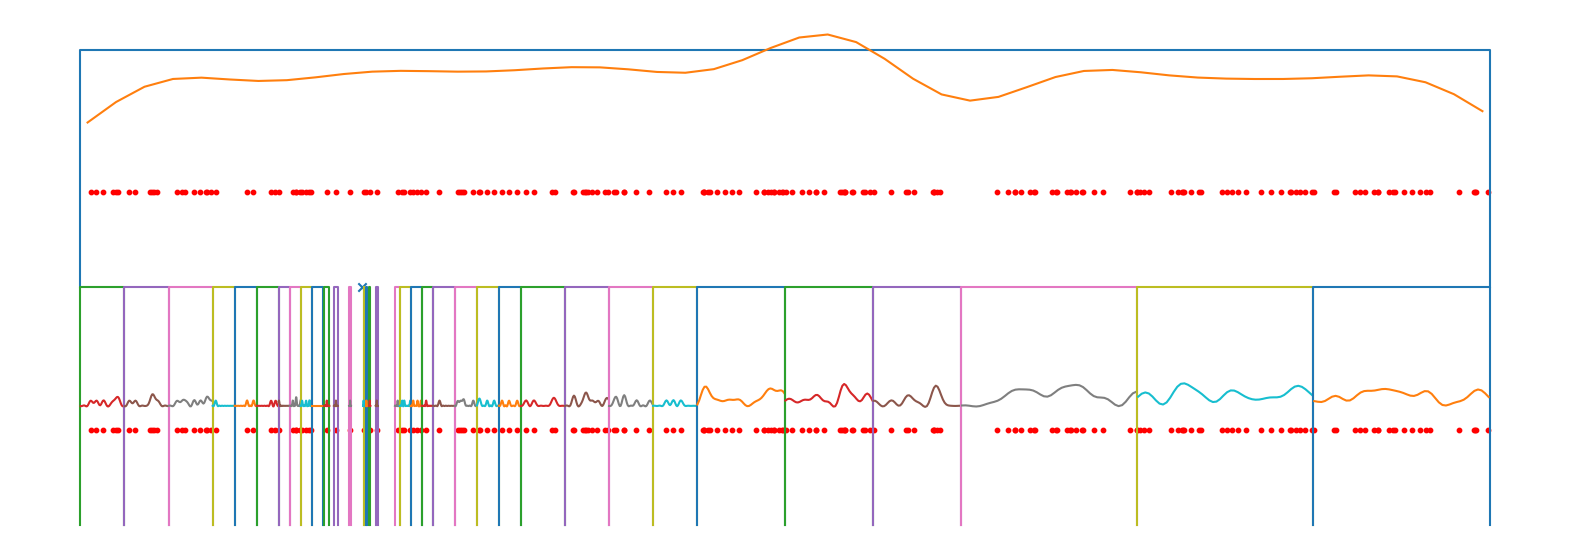

In [2]:

#plt.figure(figsize=(10, 10))
#plot_1d_tree(tree_1d, data_plotter=data_plotter)
#plt.axis('off')

ratio = 0.3
x0 = 0.2
new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
new_leavy_tree_1d = {"children": new_leaves_1d, "data": tree_1d["data"]}
x0_features = get_features(new_leaves_1d)

plt.figure(figsize=(20, 7))
plot_1d_tree(new_leavy_tree_1d, data_plotter=data_plotter)
plt.scatter([x0], [-1], marker='x')
plt.axis("off")

#print(tree_1d)
#plt.figure()
#plt.imshow(jnp.array(x0_features).imag)
#new_tree_1d = jax.tree_map(lambda *args: compute_coef_1d(*args, mu), tree_1d, is_leaf=is_leaf_1d)
#print(new_tree_1d)
#plot_1d_tree(tree_1d, color='blue', linestyle=':')
#plt.show()


In [3]:

#print(potential_from_points(x0, jnp.array(new_leaves_1d[0]["data"][1])))
#print(potential_from_feature(x0, get_feature(new_leaves_1d[0])))
val = potential_from_points(x0, x)
fmm_val = potential_from_features(x0, x0_features)
print(f"True value: {val}, FMM value: {fmm_val}, Rel. Error: {jnp.abs(val - fmm_val)/jnp.abs(val)}")

True value: 3100.22802734375, FMM value: 3100.189453125, Rel. Error: 1.2442381375876721e-05
